In [3]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk(r"C:\Users\Mehul\Downloads\archive1.zip"):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [4]:
import os
from os.path import join

import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt



In [5]:
df=pd.read_pickle(r"C:\Users\Mehul\Downloads\archive1\LSWMD.pkl")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [6]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


In [7]:
df = df.drop(['waferIndex'], axis = 1)

In [8]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
724963,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1,...",518.0,lot44029,[[Test]],[[none]],"(25, 26)"
224038,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",6328.0,lot14095,[],[],"(89, 90)"
143368,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1,...",710.0,lot9257,[],[],"(32, 29)"
208659,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3532.0,lot13290,[],[],"(64, 71)"
108026,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",846.0,lot7333,[],[],"(33, 33)"


In [9]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

c:\Users\Mehul\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\array_algos\replace.py:86: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


In [10]:
tol_wafers = df.shape[0]
tol_wafers

811457

In [11]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

C:\Users\Mehul\AppData\Local\Temp\ipykernel_18696\3684999255.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels2)


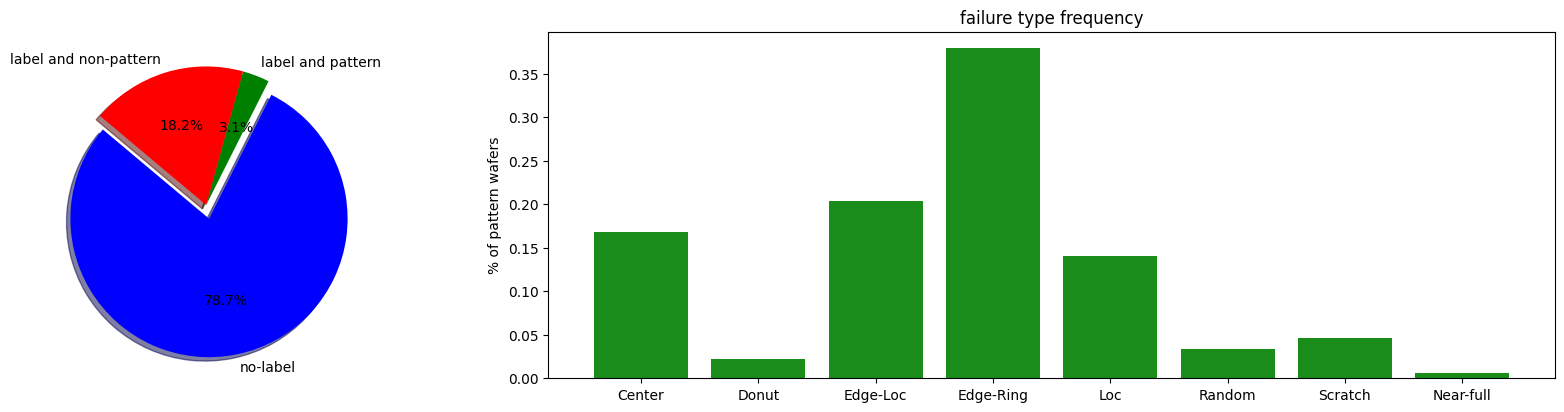

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['blue', 'green', 'red']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label and pattern','label and non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='green', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

In [ ]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [ ]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [ ]:
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


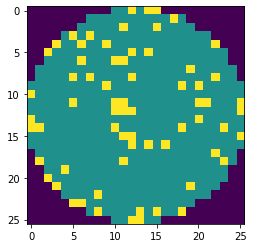

Faulty case : ['none'] 


In [ ]:
# plot 1st data
plt.imshow(x[2040])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[2040]))

In [19]:
x = x.reshape((-1, 26, 26, 1))

In [20]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [21]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


In [22]:
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [23]:
new_x.shape

(14366, 26, 26, 3)

In [24]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )


In [25]:
epoch=30
batch_size=1024


In [26]:
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)

Epoch 1/30
15/15 - 19s - loss: 0.1683 - 19s/epoch - 1s/step
Epoch 2/30
15/15 - 17s - loss: 0.0990 - 17s/epoch - 1s/step
Epoch 3/30
15/15 - 17s - loss: 0.0874 - 17s/epoch - 1s/step
Epoch 4/30
15/15 - 17s - loss: 0.0768 - 17s/epoch - 1s/step
Epoch 5/30
15/15 - 18s - loss: 0.0675 - 18s/epoch - 1s/step
Epoch 6/30
15/15 - 18s - loss: 0.0589 - 18s/epoch - 1s/step
Epoch 7/30
15/15 - 18s - loss: 0.0529 - 18s/epoch - 1s/step
Epoch 8/30
15/15 - 19s - loss: 0.0479 - 19s/epoch - 1s/step
Epoch 9/30
15/15 - 19s - loss: 0.0433 - 19s/epoch - 1s/step
Epoch 10/30
15/15 - 18s - loss: 0.0388 - 18s/epoch - 1s/step
Epoch 11/30
15/15 - 18s - loss: 0.0345 - 18s/epoch - 1s/step
Epoch 12/30
15/15 - 18s - loss: 0.0307 - 18s/epoch - 1s/step
Epoch 13/30
15/15 - 18s - loss: 0.0274 - 18s/epoch - 1s/step
Epoch 14/30
15/15 - 18s - loss: 0.0247 - 18s/epoch - 1s/step
Epoch 15/30
15/15 - 18s - loss: 0.0225 - 18s/epoch - 1s/step
Epoch 16/30
15/15 - 18s - loss: 0.0207 - 18s/epoch - 1s/step
Epoch 17/30
15/15 - 19s - loss: 0

In [27]:
encoder = models.Model(input_tensor, latent_vector)

In [28]:
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

In [29]:
encoded_x = encoder.predict(new_x)

449/449 [==============================] - 4s 8ms/step


In [30]:
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

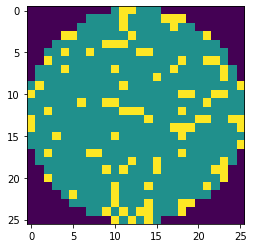

In [31]:
plt.imshow(np.argmax(new_x[3], axis=2))

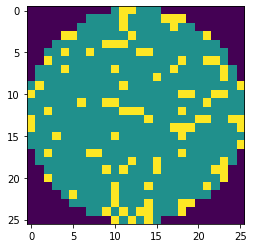

In [32]:
plt.imshow(np.argmax(new_x[3], axis=2))

In [33]:
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

In [34]:
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

3/3 [==============================] - 0s 11ms/step


In [35]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

After Generate new_x shape : (30707, 26, 26, 3), new_y shape : (30707, 1)


In [36]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 13489


In [37]:
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]

In [38]:
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [39]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (19707, 26, 26, 3), new_y shape : (19707, 1)


In [40]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 2489


In [41]:
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
# one-hot-encoding
new_y = to_categorical(new_y)

In [42]:
new_X=new_x[0:19000]
new_Y=new_y[0:19000]
test_x=new_x[19001:19706]
test_y=new_y[19001:19706]
test_x.shape

(705, 26, 26, 3)

In [43]:
x_train, x_test, y_train, y_test = train_test_split(new_X, new_Y,
                                                    test_size=0.33,
                                                    random_state=2019)

In [44]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (12730, 26, 26, 3), y : (12730, 9)
Test x: (6270, 26, 26, 3), y : (6270, 9)


In [45]:
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [46]:
model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

C:\Users\Atrija Haldar\AppData\Local\Temp/ipykernel_25008/385158899.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=1024, verbose=2)


Epoch 1/30
9/9 - 47s - loss: 1.7090 - accuracy: 0.3868 - 47s/epoch - 5s/step
Epoch 2/30
9/9 - 42s - loss: 0.7056 - accuracy: 0.7423 - 42s/epoch - 5s/step
Epoch 3/30
9/9 - 44s - loss: 0.4151 - accuracy: 0.8566 - 44s/epoch - 5s/step
Epoch 4/30
9/9 - 42s - loss: 0.2276 - accuracy: 0.9260 - 42s/epoch - 5s/step
Epoch 5/30
9/9 - 45s - loss: 0.5548 - accuracy: 0.8684 - 45s/epoch - 5s/step
Epoch 6/30
9/9 - 54s - loss: 0.3080 - accuracy: 0.9134 - 54s/epoch - 6s/step
Epoch 7/30
9/9 - 45s - loss: 0.1658 - accuracy: 0.9730 - 45s/epoch - 5s/step
Epoch 8/30
9/9 - 39s - loss: 0.0776 - accuracy: 0.9804 - 39s/epoch - 4s/step
Epoch 9/30
9/9 - 40s - loss: 0.0465 - accuracy: 0.9880 - 40s/epoch - 4s/step
Epoch 10/30
9/9 - 40s - loss: 0.0256 - accuracy: 0.9961 - 40s/epoch - 4s/step
Epoch 11/30
9/9 - 41s - loss: 0.0188 - accuracy: 0.9973 - 41s/epoch - 5s/step
Epoch 12/30
9/9 - 40s - loss: 0.0140 - accuracy: 0.9976 - 40s/epoch - 4s/step
Epoch 13/30
9/9 - 41s - loss: 0.0115 - accuracy: 0.9976 - 41s/epoch - 5s/

In [47]:
history = model.fit(x_train, y_train,
         validation_data=[x_test, y_test],
         epochs=epoch,
         batch_size=batch_size,
         )

Epoch 1/30
13/13 - 71s - loss: 1.5824 - accuracy: 0.4494 - val_loss: 1.2910 - val_accuracy: 0.5941 - 71s/epoch - 5s/step
Epoch 2/30
13/13 - 68s - loss: 0.7664 - accuracy: 0.7462 - val_loss: 0.4964 - val_accuracy: 0.8279 - 68s/epoch - 5s/step
Epoch 3/30
13/13 - 68s - loss: 0.3608 - accuracy: 0.8844 - val_loss: 0.2387 - val_accuracy: 0.9271 - 68s/epoch - 5s/step
Epoch 4/30
13/13 - 70s - loss: 0.1401 - accuracy: 0.9642 - val_loss: 0.0993 - val_accuracy: 0.9730 - 70s/epoch - 5s/step
Epoch 5/30
13/13 - 71s - loss: 0.0521 - accuracy: 0.9887 - val_loss: 0.0542 - val_accuracy: 0.9853 - 71s/epoch - 5s/step
Epoch 6/30
13/13 - 70s - loss: 0.0256 - accuracy: 0.9954 - val_loss: 0.0305 - val_accuracy: 0.9925 - 70s/epoch - 5s/step
Epoch 7/30
13/13 - 67s - loss: 0.0116 - accuracy: 0.9976 - val_loss: 0.0215 - val_accuracy: 0.9943 - 67s/epoch - 5s/step
Epoch 8/30
13/13 - 68s - loss: 0.0067 - accuracy: 0.9991 - val_loss: 0.0316 - val_accuracy: 0.9872 - 68s/epoch - 5s/step
Epoch 9/30
13/13 - 70s - loss: 0

In [48]:
score = model.score(x_test, y_test)
#print('Test Loss:', score[0])
#print('Test accuracy:', score[1])
print('Testing Accuracy:',score)

7/7 - 7s - loss: 0.0245 - accuracy: 0.9920 - 7s/epoch - 953ms/step
Testing Accuracy: 0.9920254945755005


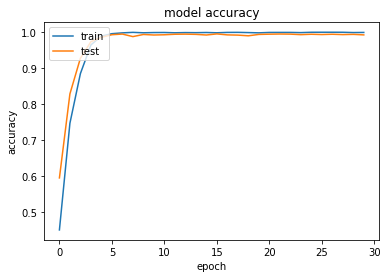

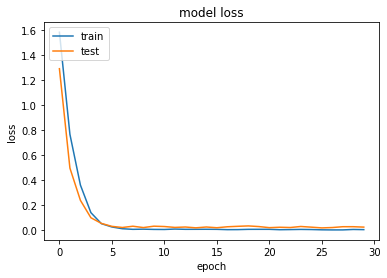

In [51]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()